# Gene-Prediction-in-Metagenomics-Fragments
Written by: Vignesh Ravindranath, Shawn Huang

This project was based on the 2008 paper ['Gene prediction in metagenomic fragments: A large scale machine learning approach'](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-217) by Hoff et at. The purpose of the project is to gain a `deeper understanding of machine learning approaches behind the Orphelia gene prediction algorithm`. 
    
    The project consists of several steps:
        1) Exploring SeqRecord Data and Structure (Genbank, Fasta)
        2) Feature Preprocessing
        3) Linear Discriminant training on high-dimentional features
        4) Binary classification neural network for coding/noncoding gene prediction
    
In the second step, high-dimensional features such as `monocodon (tricodon) usage`, `dicodon (hexcodon) usage`, and `translation initiation sites (TIS)` must be extracted from prokaryotic genomes. Monocodon and dicodon usage refer to the frequence of codons (3 basepairs) and dicodons (6 basepairs) in coding and noncoding regions. Coding proteins often have a TIS upstream of the start codon. These TIS patterns are extracted by comparing up and downstream regions for positive TIS candidates (true start codons in coding sequences) to negative TIS candidates (start codons in noncoding sequences).  
    
In the third step, linear discriminants are derived to reduce the dimensionality of the extracted features. The individual features (excluding GC content) are taken as multivariate linear regression problems and the Normal Equation is utilized to compute the weights (coefficient) matrix for each feature. 
    
In the last step, a neural network is trained on the reduced features mentioned above, in addition to the `length of the sequence` and the `GC content`.

    Summary of features:
    x1 - tricodon       - (n,64) table --reduced to a weights matrix of (64,1)
    x2 - hexcodon       - (n,4096) table --reduced to a weights matrix of (4096,1)
    x3 - positive TIS   - (n,58,64 == n,3712) table --reduced to a weights matrix of (3712,1)
    x4 - negative TIS   - (m,58,64 == m,3712) table --reduced to a weights matrix of (3712,1)
    x5 - complete seq   - 1 if fragment contains a complete gene, else 0
    x6 - incomplete seq - 0 if fragment contains a complete gene, else 1
    x7 - GC content     - (n,1) column

Test prokaryotic genome: [A fulgidus](https://www.ncbi.nlm.nih.gov/nuccore/NC_000917)

Biopython documentation: 
[Biopython Tutorial](http://biopython.org/DIST/docs/tutorial/Tutorial.html), 
[SeqFeature](https://biopython.org/docs/dev/api/Bio.SeqFeature.html)

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

import re
import itertools
import textwrap

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import Entrez
Entrez.email = "vignesh.ravindranath@gmail.com"

In [2]:
prokaryote_id = 'NC_000917' # A. fulgidus

# get seq_records (features) from GenBank file
handle = Entrez.efetch(db="sequences", id=prokaryote_id, rettype="gbwithparts", retmode="text")
seq_record = SeqIO.read(handle, "gb")
handle.close()
print(f'Fetched {prokaryote_id} GenBank records')

# get full sequence from FASTA file
handle = Entrez.efetch(db="sequences", id=prokaryote_id, rettype="fasta", retmode="text")
sequence = SeqIO.read(handle, "fasta")
handle.close()
print(f'Fetched {prokaryote_id} FASTA sequence')

dna = [sequence, sequence.reverse_complement()]

Fetched NC_000917 GenBank records
Fetched NC_000917 FASTA sequence


# Exploring SeqRecord Data and Structure

In [3]:
# find coding sequences (cds), or genes, for A. fulgidus
cds = []

for feature in seq_record.features:
    if feature.type == 'CDS':
        cds.append(feature)
        
print(len(cds))

2473


In [4]:
print(cds[0])

type: CDS
location: [4289:4784](+)
qualifiers:
    Key: codon_start, Value: ['1']
    Key: db_xref, Value: ['GeneID:1483212']
    Key: inference, Value: ['COORDINATES: protein motif:HMM:NF012415.1']
    Key: locus_tag, Value: ['AF_RS00005']
    Key: note, Value: ['Derived by automated computational analysis using gene prediction method: Protein Homology.']
    Key: old_locus_tag, Value: ['AF0003', 'AF_0003']
    Key: product, Value: ['CAP domain-containing protein']
    Key: protein_id, Value: ['WP_010877517.1']
    Key: transl_table, Value: ['11']
    Key: translation, Value: ['MKETIQLAIGVMLLAMLGCYIYITEFYHYESTEESSKAAIEYLNQLRAQNGLPPVKWNKTLYEFALERLEDMHERGYYSHYDPVTHETLIYRYVEGYVGECILNGVRGTNLLSNGLQSLFGYEEEAIDIWSKSTMHKLILTDKRFTDAAVACKYDMCVLIMTGG']



We only need relevant information from the SeqRecord such as:

    type (coding sequence)
    location (start location, stop location, and strand)
    locus_tag (id)

In [5]:
print(seq_record.id)

NC_000917.1


In [6]:
# Coding sequence on coding strand (+1)

print(cds[0].location.start.position)
print(cds[0].location.end.position)
print(cds[0].strand)
print(cds[0].qualifiers['locus_tag'][0])
print(cds[0].qualifiers['translation'][0])

start = cds[0].location.start.position
end = cds[0].location.end.position

print('---check if using correct dna strand')
seq0 = dna[0][start:end].seq
pro = seq0.translate()
print(pro)

4289
4784
1
AF_RS00005
MKETIQLAIGVMLLAMLGCYIYITEFYHYESTEESSKAAIEYLNQLRAQNGLPPVKWNKTLYEFALERLEDMHERGYYSHYDPVTHETLIYRYVEGYVGECILNGVRGTNLLSNGLQSLFGYEEEAIDIWSKSTMHKLILTDKRFTDAAVACKYDMCVLIMTGG
---check if using correct dna strand
MKETIQLAIGVMLLAMLGCYIYITEFYHYESTEESSKAAIEYLNQLRAQNGLPPVKWNKTLYEFALERLEDMHERGYYSHYDPVTHETLIYRYVEGYVGECILNGVRGTNLLSNGLQSLFGYEEEAIDIWSKSTMHKLILTDKRFTDAAVACKYDMCVLIMTGG*


In [7]:
# Coding sequence on complementary strand (-1)

print(cds[39].location.start.position)
print(cds[39].location.end.position)
print(cds[39].strand)
print(cds[39].qualifiers['locus_tag'][0])
print(cds[39].qualifiers['translation'][0])

start = cds[39].location.start.position
end = cds[39].location.end.position

print('---check if using correct dna strand')
seq39 = dna[1][::-1][start:end][::-1].seq
pro = seq39.translate()
print(pro)

44802
45561
-1
AF_RS00195
MSGYLRKRDVIITMTQFEFKQRYRGTALGLIWSLLAPFLLALVLFLVFRNMFSWVENFAAYVLVGVFVFRFFQVATSVGMHTIVGKSHLVTKTNIDRELLPLATTLSYGMSSFLEILVIVPIVHVLGGNVGFTILFLPVIHFVYIIFIFGLNLFLSSLMVYFRDLNQIWEVITNVIFFASPIVYPLTMIPESYREMYMLNPIACIIEIYRGILMENQILLEKFIYFLLISLALTFAGQLFFRRMQKRFGEVL
---check if using correct dna strand
MSGYLRKRDVIITMTQFEFKQRYRGTALGLIWSLLAPFLLALVLFLVFRNMFSWVENFAAYVLVGVFVFRFFQVATSVGMHTIVGKSHLVTKTNIDRELLPLATTLSYGMSSFLEILVIVPIVHVLGGNVGFTILFLPVIHFVYIIFIFGLNLFLSSLMVYFRDLNQIWEVITNVIFFASPIVYPLTMIPESYREMYMLNPIACIIEIYRGILMENQILLEKFIYFLLISLALTFAGQLFFRRMQKRFGEVL*


## Find Coding Sequences (CDS) or Genes

In [8]:
# Get positive ORFs (coding sequences (CDS) or genes)
l_min = sys.maxsize
cds = []
for feature in seq_record.features:
    if feature.type == 'CDS':
        tag    = feature.qualifiers['locus_tag'][0]
        start  = feature.location.start.position
        end    = feature.location.end.position
        strand = feature.strand
        seq    = dna[0][start:end] if strand == 1 else dna[1][::-1][start:end][::-1]

        # update min
        if len(seq) < l_min:
            l_min = len(seq)

        f = [SeqFeature(FeatureLocation(start,end,strand), type="CDS")]
        r = SeqRecord(seq.seq, name=tag, id=prokaryote_id, features=f)
        cds.append(r)
        
print(len(cds))

2473


In [9]:
print(cds[0])

ID: NC_000917
Name: AF_RS00005
Description: <unknown description>
Number of features: 1
Seq('ATGAAAGAGACGATTCAGCTTGCTATAGGGGTGATGCTGTTGGCCATGCTCGGT...TGA')


In [20]:
print(cds[0].features[0])

type: CDS
location: [4289:4784](+)
qualifiers:



## Find Longest Open Reading Frame (ORF)
    
An open reading frame (ORF) is part of a reading frame that has the ability to translate; it will begin with a start codon (ATG) and end with an in-frame stop codon (TAG, TGA, TAA). Prokaryotes may have alternate start codons, such as CTG, GTG, and TTG. The code below searches a sequences for all ORFs and returns the longest sequence. 

In [134]:
# Prokaryotes may have alternate start codons
START_CODONS = ['ATG','CTG','GTG','TTG']
STOP_CODONS = ['TAG','TGA','TAA']
    
def longest_orf(seq):
    all_starts = []
    for s in START_CODONS:
        # Find positions of all start codons in sequence
        matches = re.finditer(s, str(seq))
        matches_positions = [match.start() for match in matches]
        all_starts.extend(matches_positions)
    all_starts = sorted(all_starts)

    all_stops = []                                      
    for e in STOP_CODONS:
        # Find positions of all stop codons in sequence
        matches = re.finditer(e, str(seq))
        matches_positions = [match.start() for match in matches]
        all_stops.extend(matches_positions)
    all_stops = sorted(all_stops)

    # find largest ORF
    for s in all_starts:
        for e in all_stops[::-1]:
            if (e >= s) and ((e-s)%3 == 0):
                return [s,e+3]
            
    return []

In [135]:
start = cds[0].features[0].location.start.position
end = cds[0].features[0].location.end.position
test = dna[0][start:end].seq

orf = longest_orf(test)

print(test)
print()
print(dna[0][orf[0]+start:orf[1]+start].seq)

ATGAAAGAGACGATTCAGCTTGCTATAGGGGTGATGCTGTTGGCCATGCTCGGTTGCTACATCTACATTACTGAGTTCTATCACTACGAATCAACTGAAGAGAGCTCAAAAGCTGCGATTGAATATTTGAATCAGCTTAGAGCTCAGAATGGCCTGCCTCCTGTAAAGTGGAATAAAACTCTTTACGAGTTTGCGCTGGAAAGGCTTGAAGATATGCATGAAAGAGGCTATTACAGTCATTATGACCCTGTTACGCATGAGACGCTGATTTACAGATATGTTGAGGGGTATGTTGGAGAGTGTATCTTGAATGGTGTAAGAGGTACAAATCTTCTCTCCAATGGGCTTCAGTCATTATTTGGCTATGAAGAAGAAGCTATAGATATCTGGTCTAAAAGCACCATGCACAAACTCATTCTCACTGATAAACGCTTCACAGATGCCGCTGTAGCCTGCAAGTACGACATGTGTGTTTTGATTATGACGGGTGGTTGA

ATGAAAGAGACGATTCAGCTTGCTATAGGGGTGATGCTGTTGGCCATGCTCGGTTGCTACATCTACATTACTGAGTTCTATCACTACGAATCAACTGAAGAGAGCTCAAAAGCTGCGATTGAATATTTGAATCAGCTTAGAGCTCAGAATGGCCTGCCTCCTGTAAAGTGGAATAAAACTCTTTACGAGTTTGCGCTGGAAAGGCTTGAAGATATGCATGAAAGAGGCTATTACAGTCATTATGACCCTGTTACGCATGAGACGCTGATTTACAGATATGTTGAGGGGTATGTTGGAGAGTGTATCTTGAATGGTGTAAGAGGTACAAATCTTCTCTCCAATGGGCTTCAGTCATTATTTGGCTATGAAGAAGAAGCTATAGATATCTGGTCTAAAAGCACCATGCACAAACTCATTCTCACTGATAAACGCTTCACAGATGCCGCTGTAGCCTGCAAGTACGACATGTGTGTTTTGATTATGACGGGTGGTTGA


In [136]:
from Bio.Seq import Seq
#        AAA ATG TTT ATG GGG TAG 
test2 = Seq('AAAATGTTTATGGGGTAG')

# result:    ATG TTT ATG GGG TAG
orf = longest_orf(test2)
print(test2[orf[0]:orf[1]])

ATGTTTATGGGGTAG


## Find Noncoding Sequences (NCS) in Interregions
Next, we need to find the `negative ORFs` or the ORFs found in interregions (non coding regions). To do this, we will borrow code from [Iddo Friedberg and Ian MC Fleming](https://biopython.org/wiki/Intergenic_regions),  to isolate the interregions for a genome. Then, we will use a function below (`orf_finder`) based on `longest_orf` to search for all in-frame ORF in that sequence, if any.

### Find interregions

In [24]:
# Copyright(C) 2009 Iddo Friedberg & Ian MC Fleming
# Released under Biopython license. http://www.biopython.org/DIST/LICENSE
# Do not remove this comment
def get_interregions(coding_records):
    cds_list_plus = []
    cds_list_minus = []
    intergenic_records = []
    
    initials = coding_records[0].name[0:2]
    prokaryote_id = seq_record.id

    # Loop over the genome file, get the CDS features on each of the strands
    for record in coding_records:
        feature = record.features[0]
        mystart = feature.location.start.position
        myend = feature.location.end.position
        if feature.strand == -1:
            cds_list_minus.append((mystart,myend,-1))
        elif feature.strand == 1:
            cds_list_plus.append((mystart,myend,1))
        else:
            sys.stderr.write("No strand indicated %d-%d. Assuming +\n" %(mystart, myend))
            cds_list_plus.append((mystart,myend,1))
    for i,pospair in enumerate(cds_list_plus[1:]):
        # Compare current start position to previous end position
        last_end = cds_list_plus[i][1]
        this_start = pospair[0]
        if this_start - last_end >= 1:
            intergene_seq = seq_record.seq[last_end:this_start]
            strand_string = +1
            name = initials + '_NC' + str(i).zfill(5)
            feature = [SeqFeature(FeatureLocation(last_end+1,this_start,strand_string), type='interregion')]
            intergenic_records.append(SeqRecord(intergene_seq, name=prokaryote_id, id=name, features=feature))
    buffer = i
    for i,pospair in enumerate(cds_list_minus[1:]):
        last_end = cds_list_minus[i][1]
        this_start = pospair[0]
        if this_start - last_end >= 1:
            intergene_seq = seq_record.seq[last_end:this_start]
            strand_string = -1
            name = initials + '_NC' + str(i+buffer).zfill(5)
            feature = [SeqFeature(FeatureLocation(last_end+1,this_start,strand_string), type='interregion')]
            intergenic_records.append(SeqRecord(intergene_seq, name=prokaryote_id, id=name, features=feature))
    return intergenic_records

In [25]:
interregions = get_interregions(cds)
print(len(interregions))

1797


In [26]:
print(interregions[0])
print(interregions[0].features[0])

ID: AF_NC00000
Name: NC_000917.1
Description: <unknown description>
Number of features: 1
Seq('GGTGTTCAGAAAAAAGAGGAAAAGTAAAAAACAATTGCTGCGATAATCGTTTTT...CCA')
type: interregion
location: [4785:5050](+)
qualifiers:



### Find longest ORF in interregions

In [27]:
test3 = interregions[0].seq
orf = longest_orf(test3)
print(interregions[0].id)
print(test3[orf[0]:orf[1]])

AF_NC00000
GTGTTCAGAAAAAAGAGGAAAAGTAAAAAACAATTGCTGCGATAATCGTTTTTGCCGGCGTTTTTTGAAATCAGACTAAAGTGGGATTACGTAAATTTATTTGTGGAAAGTGTGACAAGGAAACAAAACTCAGACCGACGAGAGTTTAAAACCGCCTAAAGCTCTTCTCCAGCAAATCCACCACCAAATTTATTCATTAAGCTTTAACCGTTTAAAAATCCCCAAACGCCCAAACCTTAA


In [28]:
test4 = interregions[2].seq
orf = longest_orf(test4)
print(interregions[2].id)
print(test4[orf[0]:orf[1]])

AF_NC00002
TTGTTATGAACTGATTCATAA


## Find in-frame ORFs - orf-finder

In [31]:
START_CODONS = ['ATG','CTG','GTG','TTG']
STOP_CODONS = ['TAG','TGA','TAA']

def codon_pos(seq, codon_list):
    pos = []
    for codon in codon_list:
        matches = re.finditer(codon, str(seq))
        matches_positions = [match.start() for match in matches]
        pos.extend(matches_positions)
    return sorted(pos)

'''
Input: Bio.Seq.Seq
Output: returns start and end position of longest orf in a sequence
'''
def longest_orf(seq):
    all_starts = codon_pos(seq, START_CODONS)
    all_stops  = codon_pos(seq, STOP_CODONS)
           
    for s in all_starts:
        for e in all_stops[::-1]:
            if (e >= s) and ((e-s)%3 == 0):
                return [s,e+3]
    return []

'''
Input: Bio.Seq.Seq
Output: returns all in-frame start codons within an ORF sequence
'''
def orf_finder(orf_seq):
    all_starts = codon_pos(orf_seq, START_CODONS)

    # find all ORF
    orfs = []           
    for s in all_starts:
        if s%3 == 0:
            orfs.append([s,len(orf_seq)])
    return orfs

In [32]:
test5 = cds[0].seq

orfs = orf_finder(test5)
print(orfs[0:5])

for orf in orfs[0:5]:
    print(test5[orf[0]:orf[0]+3])

[[0, 495], [30, 495], [33, 495], [36, 495], [39, 495]]
ATG
GTG
ATG
CTG
TTG


In [36]:
test6 = ncs[0].seq

orfs = orf_finder(test6)
print(orfs)

for orf in orfs:
    print(test6[orf[0]:orf[0]+3])

[[0, 240], [33, 240], [36, 240], [51, 240], [102, 240]]
GTG
TTG
CTG
TTG
GTG


# Feature Preprocessing ORFs

In [2]:
# Copyright(C) 2009 Iddo Friedberg & Ian MC Fleming
# Released under Biopython license. http://www.biopython.org/DIST/LICENSE
# Do not remove this comment
def get_interregions(coding_records):
    cds_list_plus = []
    cds_list_minus = []
    intergenic_records = []
    
    initials = coding_records[0].name[0:2]
    prokaryote_id = coding_records[0].id

    # Loop over the genome file, get the CDS features on each of the strands
    for record in coding_records:
        feature = record.features[0]
        mystart = feature.location.start.position
        myend = feature.location.end.position
        if feature.strand == -1:
            cds_list_minus.append((mystart,myend,-1))
        elif feature.strand == 1:
            cds_list_plus.append((mystart,myend,1))
        else:
            sys.stderr.write("No strand indicated %d-%d. Assuming +\n" %(mystart, myend))
            cds_list_plus.append((mystart,myend,1))
    for i,pospair in enumerate(cds_list_plus[1:]):
        # Compare current start position to previous end position
        last_end = cds_list_plus[i][1]
        this_start = pospair[0]
        if this_start - last_end >= 1:
            intergene_seq = seq_record.seq[last_end:this_start]
            strand_string = +1
            tag = initials + '_NC' + str(i).zfill(5)
            feature = [SeqFeature(FeatureLocation(last_end+1,this_start,strand_string), type='interregion')]
            intergenic_records.append(SeqRecord(intergene_seq, name=tag, id=prokaryote_id, features=feature))
    buffer = i
    for i,pospair in enumerate(cds_list_minus[1:]):
        last_end = cds_list_minus[i][1]
        this_start = pospair[0]
        if this_start - last_end >= 1:
            intergene_seq = seq_record.seq[last_end:this_start]
            strand_string = -1
            tag = initials + '_NC' + str(i+buffer).zfill(5)
            feature = [SeqFeature(FeatureLocation(last_end+1,this_start,strand_string), type='interregion')]
            intergenic_records.append(SeqRecord(intergene_seq, name=tag, id=prokaryote_id, features=feature))
    return intergenic_records

In [3]:
START_CODONS = ['ATG','CTG','GTG','TTG']
STOP_CODONS = ['TAG','TGA','TAA']

def codon_pos(seq, codon_list):
    pos = []
    for codon in codon_list:
        matches = re.finditer(codon, str(seq))
        matches_positions = [match.start() for match in matches]
        pos.extend(matches_positions)
    return sorted(pos)

'''
Input: Bio.Seq.Seq
Output: returns start and end position of longest orf in a sequence
'''
def longest_orf(seq):
    all_starts = codon_pos(seq, START_CODONS)
    all_stops  = codon_pos(seq, STOP_CODONS)

    orfs = []
    found = False;            
    for s in all_starts:
        for e in all_stops[::-1]:
            if (e >= s) and ((e-s)%3 == 0):
                found = True; orfs = [s,e+3];
                break
        if found: break
            
    return orfs

'''
Input: Bio.Seq.Seq
Output: returns all in-frame start codons within an ORF sequence
'''
def orf_finder(orf_seq):
    all_starts = codon_pos(orf_seq, START_CODONS)

    # find all ORF
    orfs = []
    e = len(orf_seq)
    for s in all_starts:
        if (e >= s) and (s%3 == 0):
            orfs.append([s,e])
    return orfs

In [53]:
def preprocess_genome(seq_record, dna):
    # Get positive ORFs (coding sequences (CDS) or genes)
    l_min = 50
    cds = []
    genes = []
    for feature in seq_record.features:
        if feature.type == 'CDS':
            tag    = feature.qualifiers['locus_tag'][0]
            start  = feature.location.start.position
            end    = feature.location.end.position
            strand = feature.strand
            seq    = dna[0][start:end] if strand == 1 else dna[1][::-1][start:end][::-1]
            
            orfs = orf_finder(seq.seq)
            
            for i,orf in enumerate(orfs):
                orf_start = orf[0] + start
                orf_end = orf[1] + start
                orf_tag = tag + '.' + str(i)
                orf_seq = seq[orf[0]:orf[1]]
                
                if len(orf_seq) < l_min: continue
                
                f = [SeqFeature(FeatureLocation(orf_start, orf_end, strand), type="CDS")]
                r = SeqRecord(orf_seq.seq, name=orf_tag, id=prokaryote_id, features=f)
                cds.append(r)
                
                if i == 0: genes.append(r)
    
    # Find interregions
    interregions = get_interregions(genes)
    
    # Get negative ORFs(longest ORF in interregion)
    ## interregion (intr)
    ## longest orf (long)
    
    ncs = []
    for interregion in interregions:
        feature = interregion.features[0]
        
        tag    = interregion.name
        start  = feature.location.start.position
        end    = feature.location.end.position
        strand = feature.strand
        
        intr_seq = dna[0][start:end] if strand == 1 else dna[1][::-1][start:end][::-1]
        
        long_orf = longest_orf(intr_seq.seq)
        if not long_orf: continue
        
        long_seq = intr_seq[long_orf[0]:long_orf[1]]
        long_start = start + long_orf[0]

        # check to see if noncoding ORF is larger than l_min (smallest coding sequence length) 
        if len(long_seq) < l_min: continue
        
        orfs = orf_finder(long_seq.seq)
        
        for i, orf in enumerate(orfs):
            if orf[1]-orf[0] < l_min: continue
            
            orf_start = long_start + orf[0]
            orf_end = long_start + orf[1]
            orf_tag = tag + '.' + str(i)
            orf_seq = long_seq[orf[0]:orf[1]]
            
            f = [SeqFeature(FeatureLocation(orf_start, orf_end, strand), type="NCS")]
            r = SeqRecord(orf_seq.seq, name=orf_tag, id=prokaryote_id, features=f)
            ncs.append(r)
    
    return cds, ncs

In [7]:
prokaryote_id = 'NC_000917'

# get seq_records (features) from GenBank file
handle = Entrez.efetch(db="sequences", id=prokaryote_id, rettype="gbwithparts", retmode="text")
seq_record = SeqIO.read(handle, "gb")
handle.close()

# get full sequence from FASTA file
handle = Entrez.efetch(db="sequences", id=prokaryote_id, rettype="fasta", retmode="text")
sequence = SeqIO.read(handle, "fasta")
handle.close()

dna = [sequence, sequence.reverse_complement()]

## Find ORFs

In [54]:
import time
start_time = time.time()

_cds, _ncs = preprocess_genome(seq_record, dna)

print('%s ORFs extracted -- %s seconds' % (prokaryote_id, round(time.time() - start_time, 4)))
print(f'{len(_cds)} CDS ORFs')
print(f'{len(_ncs)} NCS ORFs')
print(f'{len(_cds)+len(_ncs)} total ORFs')

NC_000917 ORFs extracted -- 7.5356 seconds
52161 CDS ORFs
43505 NCS ORFs
95666 total ORFs


In [56]:
# Check that noncoding ORFs start and end with correct codons
for neg in _ncs[0:10]:
    print(neg.name, neg.seq[0:3], neg.seq[-3:], neg.features[0].location.start.position, neg.features[0].location.end.position)

AF_NC00000.0 GTG TAA 4785 5025
AF_NC00000.1 TTG TAA 4818 5025
AF_NC00000.2 CTG TAA 4821 5025
AF_NC00000.3 TTG TAA 4836 5025
AF_NC00000.4 GTG TAA 4887 5025
AF_NC00018.0 ATG TGA 25242 30024
AF_NC00018.1 CTG TGA 25275 30024
AF_NC00018.2 CTG TGA 25305 30024
AF_NC00018.3 TTG TGA 25308 30024
AF_NC00018.4 CTG TGA 25323 30024


## Extract Monocodon (Tri) and Dicodon (Hex) Features

In [11]:
# Produces all tri/hex codon permutations 4^n (ex. AAA, AAC,...,TTT for n=3) 
def permutations_with_replacement(n):
    for i in itertools.product(("A", "C", "G", "T"), repeat=n):
        yield i

# Function to create codon:idx dictionary. Converts codons to integers (ex. {AAA:0, AAC:1, ..., TTT:63} for n=3)
def populate_codon_idx_dict(nbases=3):
    codon_idx_dict = {}
    count = 0
    for i in permutations_with_replacement(nbases):
        key = "".join(i) #codon or dicodon sequence
        codon_idx_dict[key] = count
        count += 1
    return codon_idx_dict


TRICODON_IDX_DICT = populate_codon_idx_dict(nbases=3)
HEXCODON_IDX_DICT = populate_codon_idx_dict(nbases=6)


# Parse dna sequence into a list of codons separated by nbases
# Input: Bio.Seq.Seq
'''
Ex. Input  - AAATTTGGG
    Output - ['AAA','TTT','GGG'] if nbases=3
           = ['AAATTT','TTTGGG'] if nbases=6
'''
def codon_parser(seq, nbases):
    codon_seq = [seq[i:i+nbases] for i in range(0,len(seq),3) if (i+nbases)<len(seq)]
    return codon_seq

# Returns count of tri/hex codons in list form
# Input: Bio.Seq.Seq
def codon_feature(seq, nbases):      
    codon_idx_dict = TRICODON_IDX_DICT if nbases==3 else HEXCODON_IDX_DICT
    frame = [0]*len(codon_idx_dict)
    
    parsed_codons = codon_parser(seq, nbases)
    for codon in parsed_codons:
        frame[codon_idx_dict[codon]] += 1
    frame[codon_idx_dict[parsed_codons[-1]]] += 1 # add last codon
    
    return frame

In [63]:
_orfs = _cds + _ncs
len(_orfs)

95666

In [65]:
tri_temp = []
hex_temp = []

start_time = time.time()

for record in _orfs:
    name = record.name
    seq = record.seq
    
    t_frame = codon_feature(seq, 3)
    tri_temp.append([name] + t_frame)
    
    h_frame = codon_feature(seq, 6)
    hex_temp.append([name] + h_frame)
    
print('Codon features extracted -- %s seconds' % (round(time.time() - start_time, 4)))

_tri = pd.DataFrame(tri_temp).reset_index(drop=True)
_hex = pd.DataFrame(hex_temp).reset_index(drop=True)

Codon features extracted -- 496.2605 seconds


In [66]:
_tri.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,AF_RS00005.0,6,0,2,6,2,1,4,4,4,...,0,1,0,2,2,2,1,2,4,2
1,AF_RS00005.1,5,0,2,6,2,1,3,4,4,...,0,1,0,2,2,2,1,2,4,2
2,AF_RS00005.2,5,0,2,6,2,1,3,4,4,...,0,1,0,2,2,2,1,2,4,2
3,AF_RS00005.3,5,0,2,6,2,1,3,4,4,...,0,1,0,2,2,2,1,2,4,2
4,AF_RS00005.4,5,0,2,6,2,1,3,4,4,...,0,1,0,2,2,2,1,2,4,2


In [67]:
_hex.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,AF_RS00005.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,AF_RS00005.1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,AF_RS00005.2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,AF_RS00005.3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,AF_RS00005.4,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Extract Translation Initiation Sites (TIS)

Based on the Gene Prediction paper by Hoff et. al, translation initiation sites (TIS) for the algorithm consist of up- and downstream regions centered at a start codon. They use a 60 basepair window at window position 31. They encode the trinucleotide occurrences in that window to yield binary indicator vectors. In each of its 3712 dimensions (64 trinucleotides × 58 positions), a vector indicates whether a certain trinucleotide occurs at a particular window position.

In [101]:
# First we need to isolate the 60 basepair window with the start codon at its center (test case = cds[0])

strand = cds[0].features[0].strand
start  = cds[0].features[0].location.start.position

# find window (-/+ 30 bp from start position)
seq60 = (dna[0][start-30:start+30] if strand == 1 else dna[1][::-1][start-30:start+30][::-1]).seq
print(len(seq60))

60


In [109]:
from tensorflow.keras.utils import to_categorical

# find the trinucleotide index for each trinucleotide in the sequence (slide by 1 bp each time)
frame = [TRICODON_IDX_DICT[seq60[i:i+3]] for i in range(0,len(seq60)-2)]

# then convert the list into a 64x58 dimension frame to encode the trinucleotide occurances
tis0 = to_categorical(frame, num_classes=64).astype(int).T
tis0.shape

(64, 58)

We can visualize the frame using a heatmap - each dark square indicates the occurance of a trinucleotide at a position.

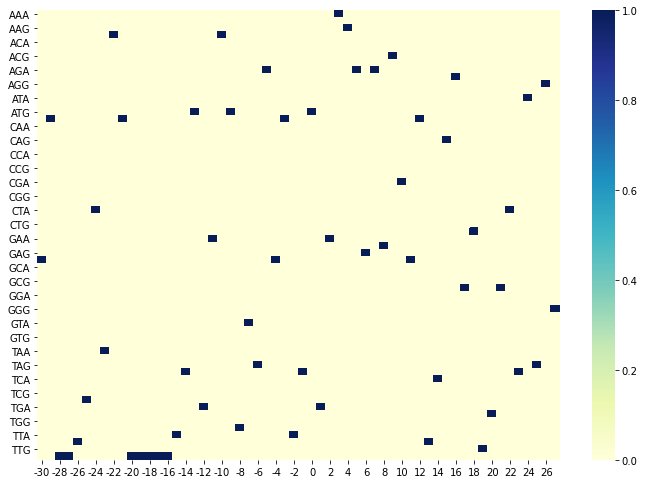

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# get codon names (keys) for y-axis labels
y_axis_labels = populate_codon_idx_dict().keys()

# get position values for x-axis labels (centered at start codon = 0)
x_axis_labels = [i for i in range(-30,28)]
df = pd.DataFrame(tis0, columns=x_axis_labels, index=y_axis_labels)

# plot heatmap
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df, cmap="YlGnBu")

In [114]:
tis_temp = []

start_time = time.time()

for record in _orfs:
    name = record.name
    strand = record.features[0].strand
    start  = record.features[0].location.start.position

    # create frame (58x64) for TIS pos
    seq60 = (dna[0][start-30:start+30] if strand == 1 else dna[1][::-1][start-30:start+30][::-1]).seq

    frame = [TRICODON_IDX_DICT[seq60[i:i+3]] for i in range(0,len(seq60)-2)]
    tis = list(to_categorical(frame, num_classes=64).astype(int).T.reshape(-1))
    tis_temp.append([name] + tis)
    
print('TIS features extracted -- %s seconds' % (round(time.time() - start_time, 4)))

_tis = pd.DataFrame(tis_temp).reset_index(drop=True)
_tis.head()

TIS features extracted -- 279.2417 seconds


,0,1,2,3,4,5,6,7,8,9,...,3703,3704,3705,3706,3707,3708,3709,3710,3711,3712
0,AF_RS00005.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AF_RS00005.1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AF_RS00005.2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AF_RS00005.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AF_RS00005.4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
